In [15]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

from hydradx.model.amm.global_state import historical_prices, dynamic_fees_from_historical_prices

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, value_assets
from model.amm.agents import Agent
from model.amm.trade_strategies import arb_tkn_pair
from model.amm.global_state import GlobalState

# Set up DOT price path

In [16]:
# we will hack the model in by setting fees based on oracle
# we need an oracle path, that is a projected price path of e.g. DOT
dot_oracle_start = 5
dot_oracle_end = 10
dot_oracle_steps = 100
dot_oracle = [dot_oracle_start + (dot_oracle_end - dot_oracle_start) * i / dot_oracle_steps for i in range(dot_oracle_steps)]
# dot_oracle = [6] * dot_oracle_steps
fixed_steps = 100
dot_oracle = dot_oracle + [dot_oracle_end] * fixed_steps
time_steps = dot_oracle_steps + fixed_steps

# Set up initial Omnipool state

In [17]:
# next we set up initial Omnipool state
init_prices = {'DOT': dot_oracle_start}

tokens = {
    'DOT': {'liquidity': 1000000, 'LRNA_price': init_prices['DOT']},
    'USDT': {'liquidity': 100000000, 'LRNA_price': 1},
    'HDX': {'liquidity': 1000000, 'LRNA_price': 0.01},
}

init_omnipool = OmnipoolState(
    tokens=tokens,
    lrna_fee=0.0005,
    asset_fee=0.0025,
    preferred_stablecoin='USDT',
)

# Model static fees

In [18]:
agent_holdings = {'USDT': 10000000}
arb_agent = Agent(unique_id='arb_agent', trade_strategy=arb_tkn_pair('omnipool', tkn_pair=['DOT', 'USDT']), holdings=agent_holdings)
price_paths = [{'DOT': dot_oracle[i]} for i in range(time_steps)]
evolve_fn = historical_prices(price_paths)
init_state = GlobalState(agents={'arb_agent': arb_agent}, pools={'omnipool': init_omnipool}, external_market=init_prices, evolve_function=evolve_fn)
steps = time_steps-1
print(f'Running with {steps} time steps')
events = run.run(init_state, time_steps=steps)
print(len(events))

Running with 199 time steps
Starting simulation...
Execution time: 0.959 seconds.
199


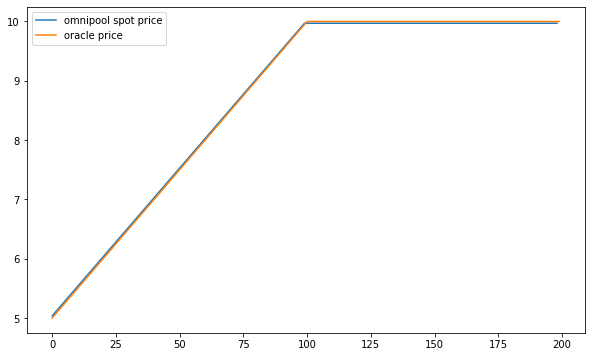

In [19]:
# check spot price
omnipool_spot_prices = [events[i].pools['omnipool'].price('DOT', 'USDT') for i in range(len(events))]
plt.figure(figsize=(10, 6))
plt.plot(omnipool_spot_prices, label='omnipool spot price')
plt.plot(dot_oracle, label='oracle price')
plt.legend()
plt.show()

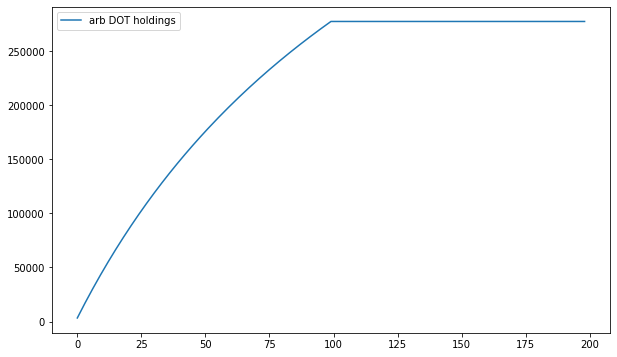

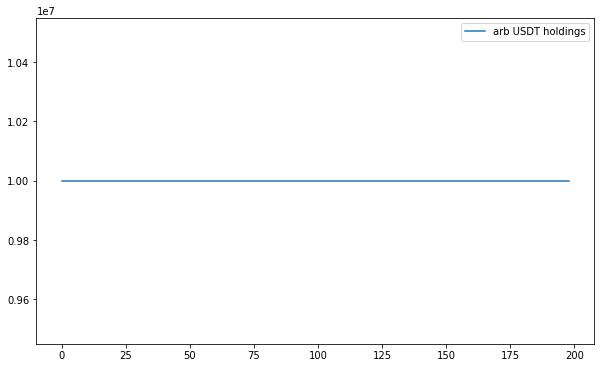

In [20]:
# check arb holdings
plt.figure(figsize=(10, 6))
plt.plot([events[i].agents['arb_agent'].holdings['DOT'] for i in range(len(events))], label='arb DOT holdings')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot([events[i].agents['arb_agent'].holdings['USDT'] for i in range(len(events))], label='arb USDT holdings')
plt.legend()
plt.show()

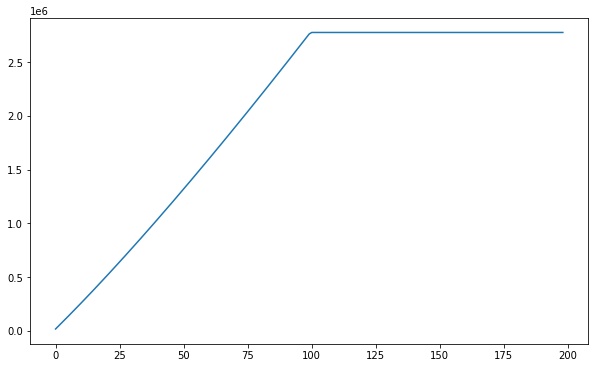

In [21]:
# check arb_agent asset value
plt.figure(figsize=(10, 6))
hold_value = [value_assets(prices=prices, assets=arb_agent.holdings) for prices in price_paths]
plt.plot([value_assets(prices=price_paths[i], assets=events[i].agents['arb_agent'].holdings) - hold_value[i] for i in range(len(events))], label='arb agent asset value')
plt.show()


In [22]:
print(events[-1].pools['omnipool'].liquidity)
delta_USDT = events[-1].pools['omnipool'].liquidity['USDT'] - 100000000
delta_DOT = 1000000-events[-1].pools['omnipool'].liquidity['DOT']
print(delta_USDT)
print(delta_DOT)
print(delta_USDT / delta_DOT)

{'DOT': 722383.6123962827, 'USDT': 101966046.30211368, 'HDX': 1000000}
1966046.302113682
277616.3876037173
7.081881293405882


In [23]:
agent_holdings = {'USDT': 10000000}
arb_agent = Agent(unique_id='arb_agent', trade_strategy=arb_tkn_pair('omnipool', tkn_pair=['DOT', 'USDT']), holdings=agent_holdings)
evolve_fn = dynamic_fees_from_historical_prices(price_paths, buffer=0.005, mult=0.9)
init_state = GlobalState(agents={'arb_agent': arb_agent}, pools={'omnipool': init_omnipool}, external_market=init_prices, evolve_function=evolve_fn)
print(f'Running with {steps} time steps')
events = run.run(init_state, time_steps=steps)
print(len(events))

Running with 199 time steps
Starting simulation...
Execution time: 0.905 seconds.
199


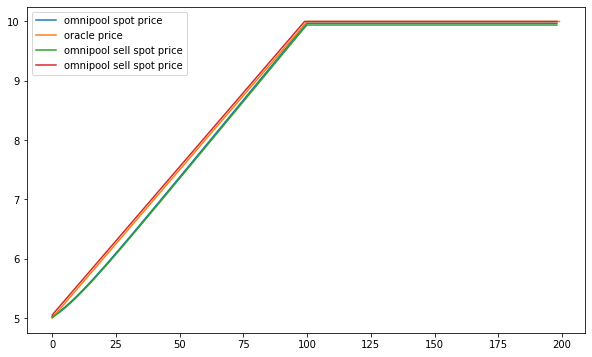

In [24]:
omnipool_spot_prices = [events[i].pools['omnipool'].price('DOT', 'USDT') for i in range(len(events))]
omnipool_sell_spot_prices = [events[i].pools['omnipool'].sell_spot('DOT', 'USDT') for i in range(len(events))]
omnipool_buy_spot_prices = [events[i].pools['omnipool'].buy_spot('DOT', 'USDT') for i in range(len(events))]
plt.figure(figsize=(10, 6))
plt.plot(omnipool_spot_prices, label='omnipool spot price')
plt.plot(dot_oracle, label='oracle price')
plt.plot(omnipool_sell_spot_prices, label='omnipool sell spot price')
plt.plot(omnipool_buy_spot_prices, label='omnipool sell spot price')
plt.legend()
plt.show()

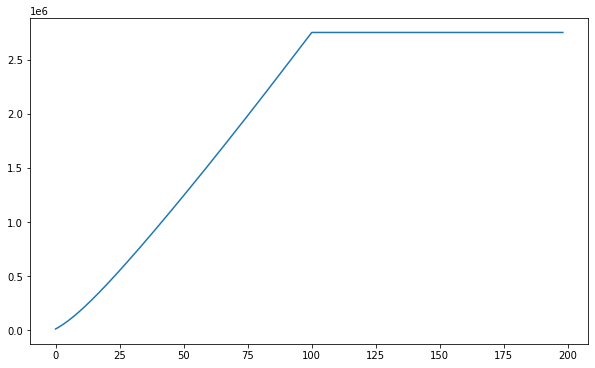

In [25]:
plt.figure(figsize=(10, 6))
hold_value = [value_assets(prices=prices, assets=arb_agent.holdings) for prices in price_paths]
plt.plot([value_assets(prices=price_paths[i], assets=events[i].agents['arb_agent'].holdings) - hold_value[i] for i in range(len(events))], label='arb agent asset value')
plt.show()

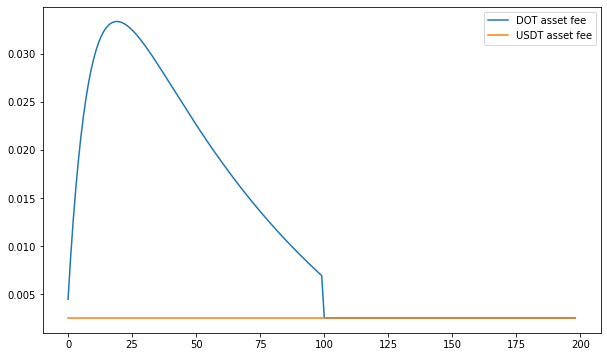

0.0025


In [26]:
plt.figure(figsize=(10, 6))
dot_asset_fee = [events[i].pools['omnipool'].asset_fee('DOT') for i in range(len(events))]
usdt_asset_fee = [events[i].pools['omnipool'].asset_fee('USDT') for i in range(len(events))]
plt.plot(dot_asset_fee, label='DOT asset fee')
plt.plot(usdt_asset_fee, label='USDT asset fee')
plt.legend()
plt.show()
print(dot_asset_fee[-1])


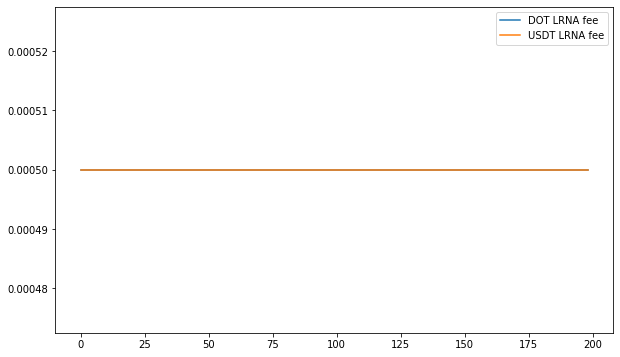

In [27]:
plt.figure(figsize=(10, 6))
dot_lrna_fee = [events[i].pools['omnipool'].lrna_fee('DOT') for i in range(len(events))]
usdt_lrna_fee = [events[i].pools['omnipool'].lrna_fee('USDT') for i in range(len(events))]
plt.plot(dot_lrna_fee, label='DOT LRNA fee')
plt.plot(usdt_lrna_fee, label='USDT LRNA fee')
plt.legend()
plt.show()


In [28]:
print(events[-1].pools['omnipool'].liquidity)
delta_USDT = events[-1].pools['omnipool'].liquidity['USDT'] - 100000000
delta_DOT = 1000000-events[-1].pools['omnipool'].liquidity['DOT']
print(delta_USDT)
print(delta_DOT)
print(delta_USDT / delta_DOT)

{'DOT': 724864.842160238, 'USDT': 101987727.98059508, 'HDX': 1000000}
1987727.980595082
275135.15783976205
7.224551003229944
